# The plan
* Import the data from the flat CSV
* Preprocess the relevant fields to remove junk
* Construct a graph of the most important relationships
* Pass that graph into a node2vec constructor so to generate random walks
* Fit these sequences with a word2vec model, and save to another CSV
* Extract the embeddings, and visualise them

In [1]:
# Data handling and processing 
import pandas as pd
from node2vec import Node2Vec
import networkx as nx
from gensim.models import Word2Vec
pd.options.mode.chained_assignment = None

# For visualizing the embeddings
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans
%matplotlib inline

# Helper utilities, and parsing of inputs
from tqdm import tqdm
import ast
import re
from unidecode import unidecode 

# Fetch and preprocess the data
The original dataset has 2 million rows in it, so this might take a while. The original data can be found by following the link in the README.

In [3]:
# A helper function for preprocessing the rows of this dataset:
def process_text(string):
    # convert it to a python object
    tokenized = ast.literal_eval(string.lower())
    
    # remove some junk characters
    filtered = [unidecode(string).lower() for string in tokenized]
    filtered = [re.sub(r'[^\w ]+', '', string) for string in filtered]
    filtered = [re.sub(r'[\-\_0-9]+', ' ', string) for string in filtered]
    
    # strip whitespace
    stripped = [string.strip() for string in filtered]
    
    # remove empty strings
    result = [string for string in stripped if string]
    
    return result

# Read the file in as as pandas DF
# How many rows of this huge dataset do we want? None = all of them
print("Loading data from disk")
fraction = 0.25
data = pd.read_csv('./data/full_dataset.csv',
                   usecols = ['title', 'ingredients', 'directions', 'NER']
                  ).sample(frac = fraction)

# Use the function defined above to convert the list of string representations into a list of lists
tokenized = [process_text(string) for string in tqdm(data['NER'].tolist(), desc = 'tokenizing')]

# How many ingredients are we working with? And how are they distributed?
ingredients = {}
for recipe in tqdm(tokenized, desc = 'tallying'):
    for ingredient in recipe: 
        if ingredient not in ingredients.keys(): 
            ingredients[ingredient] = 1
        else: 
            ingredients[ingredient] += 1

Loading data from disk


tallying: 100%|█████████████████████| 557786/557786 [00:01<00:00, 433844.70it/s]


In [4]:
# Make it into a pandas dataframe
ingredients_df = pd.DataFrame({"cleaned_ingredients": key, "recipes":value} for key,value in ingredients.items())
ingredients_df.to_csv('ingredient_counts.csv', header = True, index = False)

In [5]:
data['cleaned_ingredients'] = tokenized
data['id'] = data.index

In [39]:
# Explode the list of ingredients for each recipe so we can filter and self-join later
print('exploding')
exploded = data[['id', 'cleaned_ingredients']].explode(column = 'cleaned_ingredients')


# Remove ingredients that appear in fewer than n_recipes in total
print('filtering ingredients')
n_recipes = 1000
reduced = ingredients_df[ingredients_df['recipes'] > n_recipes].sort_values('recipes', axis = 0, ascending = False)[['cleaned_ingredients']]

# Use the reduced list to filter down the exploded ingredients list
exploded = pd.merge(exploded, reduced, on = 'cleaned_ingredients', how = 'inner')

# Construct edges with a self join
edges = pd.merge(exploded, exploded, on = 'id')

# Remove self-loops
edges = edges[edges['cleaned_ingredients_x'] != edges['cleaned_ingredients_y']]

# Aggregate edges into a weights column
print("aggregating edges")
edges = (edges
         .groupby(['cleaned_ingredients_x', 'cleaned_ingredients_y'])
         .size()
         .reset_index(name = 'weight')
        )

# Filter out sparse edges (ingredients that occur very infrequently with each other)
edge_weight = 1
edges_filtered = edges[edges['weight']>=edge_weight]

# Scale the edge weights a bit so we're not working with huge numbers
edges_filtered['weight'] = edges_filtered['weight'] / max(edges_filtered['weight'])

exploding
filtering ingredients
aggregating edges


In [40]:
g = (nx
     .convert_matrix
     .from_pandas_edgelist(edges_filtered, 
                           source = 'cleaned_ingredients_x', 
                           target = 'cleaned_ingredients_y',
                           edge_attr = True)
            .to_undirected()
    )

In [41]:
print(max([b for (a,b) in list(g.degree())]))
print(len(g.nodes()))

496
497


In [42]:
# We bias the random walk to explore outwards so that it finds ingredients that are good substitutes.
nv = Node2Vec(g, 
              walk_length=50, 
              num_walks=200, 
              workers=12,
              p=2.5,
              q=0.5,
              weight_key = 'weight'
             ) 

Generating walks (CPU: 12): 100%|██████████| 16/16 [00:42<00:00,  2.66s/it]


In [43]:
# We use Word2Vec directly instead of Node2Vec because of a keyword bug in this version of the N2V implementation
fit = Word2Vec(sentences=nv.walks, 
               vector_size=32, 
               window=10, 
               min_count=1, 
               workers=12)

In [44]:
ingredients = ['garlic', 'olive oil']
print(fit.wv.most_similar(positive = ingredients, topn=3))

[('red pepper', 0.8156924247741699), ('extra virgin olive oil', 0.7379904389381409), ('fresh parsley', 0.696958065032959)]


In [70]:
kmeans = KMeans(n_clusters=15, random_state=0).fit_predict(fit.wv.vectors)

# Save the vectors as a CSV file for later
vectors = dict(zip(fit.wv.index_to_key,[list(vector) for vector in list(fit.wv.vectors)]))
vectors_df = pd.DataFrame(vectors).T
vectors_df.reset_index(inplace = True)
vectors_df.columns = [str(col) for col in vectors_df.columns]
vectors_df.set_index('index', inplace = True)
vectors_df['cluster'] = kmeans
vectors_df.to_csv("food_vectors.csv", header = True, index = False)

In [71]:
# Create a TSNE model and plot it
labels = []
tokens = []
sizes = []
colors = []

for word in fit.wv.index_to_key:
    tokens.append(fit.wv[word])
    labels.append(word)
    sizes.append((ingredients_df[ingredients_df['cleaned_ingredients']==word].recipes)**0.25)
    colors.append(vectors_df.loc[word]['cluster'])

In [77]:
tsne_model = TSNE(perplexity=25, 
                  n_components=3, 
                  init='pca', 
                  n_iter=2500, 
                  random_state=23,
                  n_jobs = 12)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []
z = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
    z.append(value[2])

In [82]:
labels_filtered = []
for (name, cluster) in zip(labels, kmeans): 
    if cluster ==2: 
        labels_filtered.append(name) 
    else:
        labels_filtered.append(None)

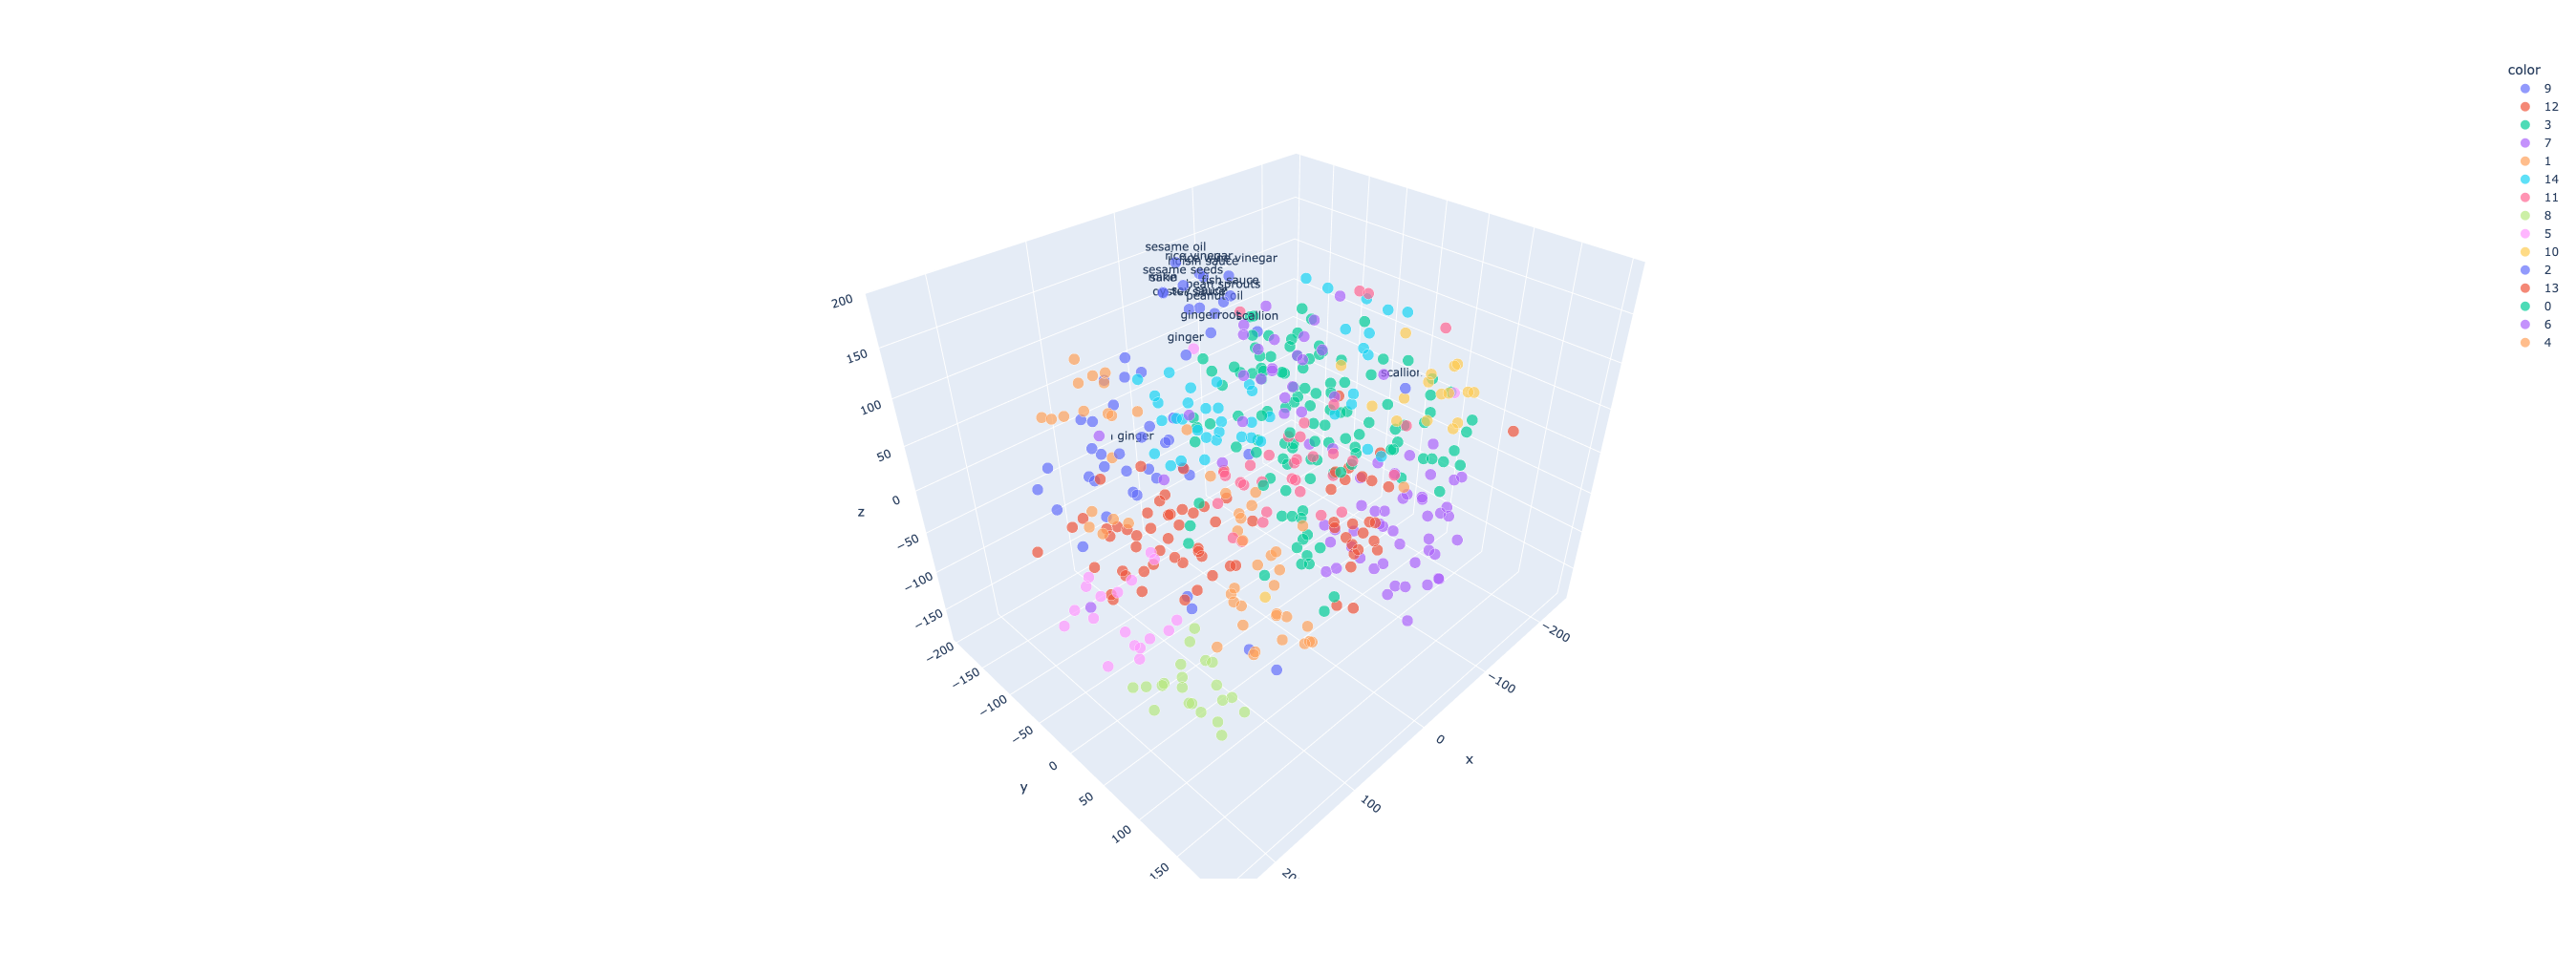

In [83]:
fig = px.scatter_3d(
    x=x, y=y, z=z,
    size = [1.2 for i in sizes],
    #size = [s.values[0]**2 for s in sizes],
    #title=f'Total Explained Variance: {total_var:.2f}%',
    text=labels_filtered,
    height = 1000, 
    width = 1400, 
    color = [str(elem) for elem in kmeans]
)

#fig.update_traces(
#    textfont_size=[s.values[0]/2 for s in sizes]
#)
fig.show()